# Analysis of Tailored Forming Processes for Manufacturing Components
This Jupyter notebook contains several analyses of scholarly knowledge from scientific publications on the topic of *Tailored Forming Processes for Manufacturing Components with Bearing Raceways Using Different Material Combinations* from the research field *Mechanical Process Engineering*. These analyses are based on domain-specific questions about the described scholarly knowledge posed by domain experts in this research area. While the individual questions are presented below for overview, their details are explained in the respective section of this Jupyter notebook.

Questions:
1. How often are which qualities of the manufactured components examined in which tailored forming process steps?
2. Which material combinations are used for which manufactured components?
3. How does the tailored forming process steps affect the hardness in the cladding layer of the manufactured components?
4. For which material combinations can defects occur in the manufactured components in which tailored forming process steps?
5. What service lives can be achieved for manufactured components subjected depending on the material combination?
6. What manufacturing methods have been used in the individual steps of the tailored forming processes described to build which component?
7. How often are which manufacturing methods used in total in all described processes?
8. Eine Frage die sich mit der Microstructure befasst wäre gut.

For the description of the scholarly knowledge from such publications in this research field, we developed a template to consistently describe a tailored forming process for manufacturing components. This description includes the entire process with its steps, source materials, and resulting components with their qualities. The template makes it possible to describe each step of a process in terms of its sequence in the process, its input, its manufacturing method used, and its output with the examined qualities, their associated measurement methods, and measurement results.

## Loading data from ORKG SPAQRL endpoint
First, the data from the publications on *Tailored Forming Processes for Manufacturing Components* is loaded from the Open Research Knowledge Graph ([ORKG](https://www.orkg.org/orkg/)).

In [62]:
%matplotlib widget
import sparql_dataframe
import seaborn as sns
import matplotlib.pyplot as plt

ENDPOINT_URL = "https://www.orkg.org/orkg/triplestore"

PREFIXES =  """
            PREFIX orkgr: <http://orkg.org/orkg/resource/>
            PREFIX orkgc: <http://orkg.org/orkg/class/>
            PREFIX orkgp: <http://orkg.org/orkg/predicate/>
            PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
            PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
            PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
            """

query = """
        SELECT ?contrib_url ?contrib ?component ?step_number ?step_name ?manufacture_method ?layer ?material ?measure_method ?quality ?num_value ?textual_value ?avg_range (xsd:float(?lower_num_value) AS ?min_value) (xsd:float(?upper_num_value) AS ?max_value) ?unit
        WHERE {
                #Get all steps and their resulting component (output) and measurement methods (method)
                ?contrib_url a orkgc:C21027.
                ?contrib_url orkgp:P7108 ?process_plan;
                        rdfs:label ?contrib.
                ?process_plan orkgp:P44026 ?step_n.
                ?step_n orkgp:P7111 ?step_n_name;
                        orkgp:P44025* ?step_n_plus_1;
                        orkgp:P44012 ?method_n;
                        orkgp:HAS_METHOD ?manufacturing_method_n;
                        orkgp:P30012 ?output_n.
                ?step_n_plus_1 orkgp:P7111 ?step_n_plus_1_name;
                                orkgp:P44012 ?method_n_plus_1;
                                orkgp:HAS_METHOD ?manufacturing_method_n_plus_1;
                                orkgp:P30012 ?output_n_plus_1.
                BIND(IF(?step_n_plus_1 = ?step_n, ?method_n, ?method_n_plus_1) AS ?method_resrc)
                BIND(IF(?step_n_plus_1 = ?step_n, ?manufacturing_method_n, ?manufacturing_method_n_plus_1) AS ?manu_method_resrc)
                BIND(IF(?step_n_plus_1 = ?step_n, ?output_n, ?output_n_plus_1) AS ?output)
                
                #Get all qualities from all layers of the resulting component
                ?output orkgp:P28005 ?layer_resrc;
                        orkgp:P7111 ?component_type.
                ?component_type rdfs:label ?component.
                ?layer_resrc orkgp:P3 ?layer_type; #all layers
                        orkgp:P7000 ?material_resrc.
                ?layer_type rdfs:label ?layer.
                
                ?material_resrc orkgp:P42007 ?material_type.
                ?material_type rdfs:label ?material.
                
                #Get the manufacturing method for each step
                ?manu_method_resrc orkgp:P7111 ?manu_method_name.
                ?manu_method_name rdfs:label ?manufacture_method.
                
                Optional{?material_resrc orkgp:P7113 ?quality_resrc.
                        ?quality_resrc orkgp:P7111 ?quality_type;
                                        orkgp:P44022 ?measurement.
                        ?quality_type rdfs:label ?quality.
                        #Get the measurement method for each measurement
                        Optional{?method_resrc orkgp:P7111 ?method_name;
                                                orkgp:HAS_RESULTS ?measurement.
                                ?method_name rdfs:label ?measure_method.}
                        #Get the range and unit of the resulting component
                        OPTIONAL{?measurement orkgp:P44010 ?range.
                                ?range orkgp:P43248 ?lower_value;
                                        orkgp:P43247 ?upper_value.
                                ?upper_value orkgp:P42000 ?range_unit.
                                ?lower_value orkgp:P44011 ?lower_num_value.
                                ?upper_value orkgp:P44011 ?upper_num_value.}
                        #Get the measurement value and unit of the resulting component
                        OPTIONAL{?measurement orkgp:HAS_VALUE ?value.
                                ?value orkgp:P44011 ?measurement_value.
                                BIND(IF(REGEX(?measurement_value, "^\\\d*\\\.?\\\d*$", "i"), xsd:float(?measurement_value), "") AS ?num_value)
                                BIND(IF(REGEX(?measurement_value, "^\\\d*\\\.?\\\d*$", "i"), "", ?measurement_value) AS ?textual_value)
                                OPTIONAL{?value orkgp:P42000 ?value_unit.}
                                }
                        }
                
                #If no value is reported, calculate the average value based on the reported range
                BIND(IF (BOUND(?value), "", (((xsd:float(?lower_num_value) + xsd:float(?upper_num_value)) / 2) AS ?avg_value) ) AS ?avg_range).
                
                #Get the unit either from the value or the range
                BIND(IF (BOUND(?value), ?value_unit, ?range_unit) AS ?unit_resrc).
                OPTIONAL {?unit_resrc rdfs:label ?unit.}
                
                #Get the number of the step in the process plan
                ?step_n_plus_1_name rdfs:label ?step_name.
                BIND(STR(?step_name) AS ?step)
                VALUES(?step ?step_number){("Deposition welding" 1) ("Hot forming" 2) ("Cooling" 3) ("Heat treatment" 4) ("Machining" 5)}  
        }
        GROUP BY ?contrib_url ?contrib ?component ?step_number ?step_name ?manufacture_method ?layer ?material ?measure_method ?quality
        ORDER BY ?contrib_url ?contrib ?component ?step_number ?step_name ?manufacture_method ?layer ?material ?measure_method ?quality
        """
tf_data = sparql_dataframe.get(ENDPOINT_URL, PREFIXES+query)
tf_data.head()

,contrib_url,contrib,component,step_number,step_name,manufacture_method,layer,material,measure_method,quality,num_value,textual_value,avg_range,min_value,max_value,unit
0,http://orkg.org/orkg/resource/R145728,1 Cladding Layer Component (100Cr6),Bearing washer,1,Deposition welding,Plasma-transferred arc welding,Base material,C22.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,http://orkg.org/orkg/resource/R145728,1 Cladding Layer Component (100Cr6),Bearing washer,1,Deposition welding,Plasma-transferred arc welding,Base material,C22.8,Hardness profile,Hardness,NaN,NaN,150.0,100.0,200.0,HV0.5
2,http://orkg.org/orkg/resource/R145728,1 Cladding Layer Component (100Cr6),Bearing washer,1,Deposition welding,Plasma-transferred arc welding,Base material,C22.8,Micrograph,Microstructure,NaN,ferritic-pearlitic,NaN,NaN,NaN,NaN
3,http://orkg.org/orkg/resource/R145728,1 Cladding Layer Component (100Cr6),Bearing washer,1,Deposition welding,Plasma-transferred arc welding,Cladding layer,100Cr6,Hardness profile,Hardness,NaN,NaN,400.0,350.0,450.0,HV0.5
4,http://orkg.org/orkg/resource/R145728,1 Cladding Layer Component (100Cr6),Bearing washer,1,Deposition welding,Plasma-transferred arc welding,Cladding layer,100Cr6,Micrograph,Microstructure,NaN,pearlitic,NaN,NaN,NaN,NaN


## 1. Question: How often are which qualities of the manufactured components examined in which tailored forming process steps?
Based on this question, we want to know which qualities of the manufactured components are typically reported in which steps of the tailored forming process. On the one hand, this information shows which qualities are reported prominently in scientific publications on tailored forming processes. On the other hand, the answer to this question also shows in which steps little research has been reported in general and for specific qualities.

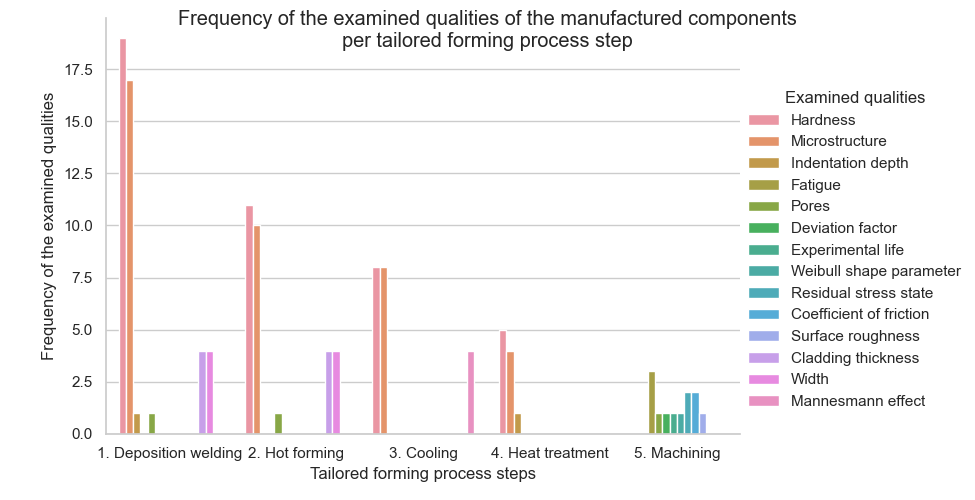

In [63]:
steps = tf_data.sort_values('step_number')[['step_number', 'step_name']].drop_duplicates()
steps["step"] = steps['step_number'].astype(str) + '. ' + steps['step_name']

sns.set_style('whitegrid')
sns.set_context('notebook')
g = sns.catplot(x='step_number', data=tf_data, hue='quality', kind='count', height=5, aspect=1.5, facet_kws={'legend_out': True})
g.fig.suptitle('Frequency of the examined qualities of the manufactured components\nper tailored forming process step')
g.set(xlabel='Tailored forming process steps', ylabel='Frequency of the examined qualities')
g.set_xticklabels(steps['step'])
g._legend.set_title('Examined qualities')
plt.show()

## 2. Question: Which material combinations are used for which manufactured components?
Due to the large number of combinations of materials for different manufactured components, it is necessary to know which material combinations have already been investigated for which manufactured components. On the one hand, this overview allows researchers to find out whether similar studies already exist so that they can compare these results with their own results. On the other hand, with this overview it is possible to find out which combinations of materials for certain manufactured components have not yet been studied and thus represent a gap in science that needs to be closed.

In [64]:
material_data = tf_data.loc[:,['contrib_url','layer', 'material', 'component']].drop_duplicates()
material_data.pivot(index=['contrib_url', 'component'], columns='layer')

material  \
layer                                                         Base material   
contrib_url                           component                               
http://orkg.org/orkg/resource/R145728 Bearing washer                  C22.8   
http://orkg.org/orkg/resource/R145731 Bearing washer                  C22.8   
http://orkg.org/orkg/resource/R145734 Bearing washer                   S235   
http://orkg.org/orkg/resource/R162733 Shaft with bearing seat         C22.8   
http://orkg.org/orkg/resource/R162788 Shaft with bearing seat         C22.8   
http://orkg.org/orkg/resource/R162790 Shaft with bearing seat         C22.8   
http://orkg.org/orkg/resource/R171849 Shaft with bearing seat       20MnCr5   
http://orkg.org/orkg/resource/R172160 Shaft with bearing seat       20MnCr5   
http://orkg.org/orkg/resource/R172247 Shaft with bearing seat       20MnCr5   
http://orkg.org/orkg/resource/R172322 Shaft with bearing seat       20MnCr5   

                                                                              
layer                                                         Cladding layer  
contrib_url                           component                               
http://orkg.org/orkg/resource/R145728 Bearing washer                  100Cr6  
http://orkg.org/orkg/resource/R145731 Bearing washer                   41Cr4  
http://orkg.org/orkg/resource/R145734 Bearing washer              X45CrSi9-3  
http://orkg.org/orkg/resource/R162733 Shaft with bearing seat   Delcrome 253  
http://orkg.org/orkg/resource/R162788 Shaft with bearing seat     Stellite 6  
http://orkg.org/orkg/resource/R162790 Shaft with bearing seat         100Cr6  
http://orkg.org/orkg/resource/R171849 Shaft with bearing seat     X45CrSi9-3  
http://orkg.org/orkg/resource/R172160 Shaft with bearing seat     X45CrSi9-3  
http://orkg.org/orkg/resource/R172247 Shaft with bearing seat     X45CrSi9-3  
http://orkg.org/orkg/resource/R172322 Shaft with bearing seat     X45CrSi9-3

## 3. Question: How does the tailored forming process affect the hardness in the cladding layer of the manufactured components?
In Tailored Forming, the hardness in the cladding layer of a manufactured component is decisive for its use since this layer is subjected to high stresses during use. For this reason, the question arises as to how the individual process steps affect the hardness in the cladding layer of a manufactured component.

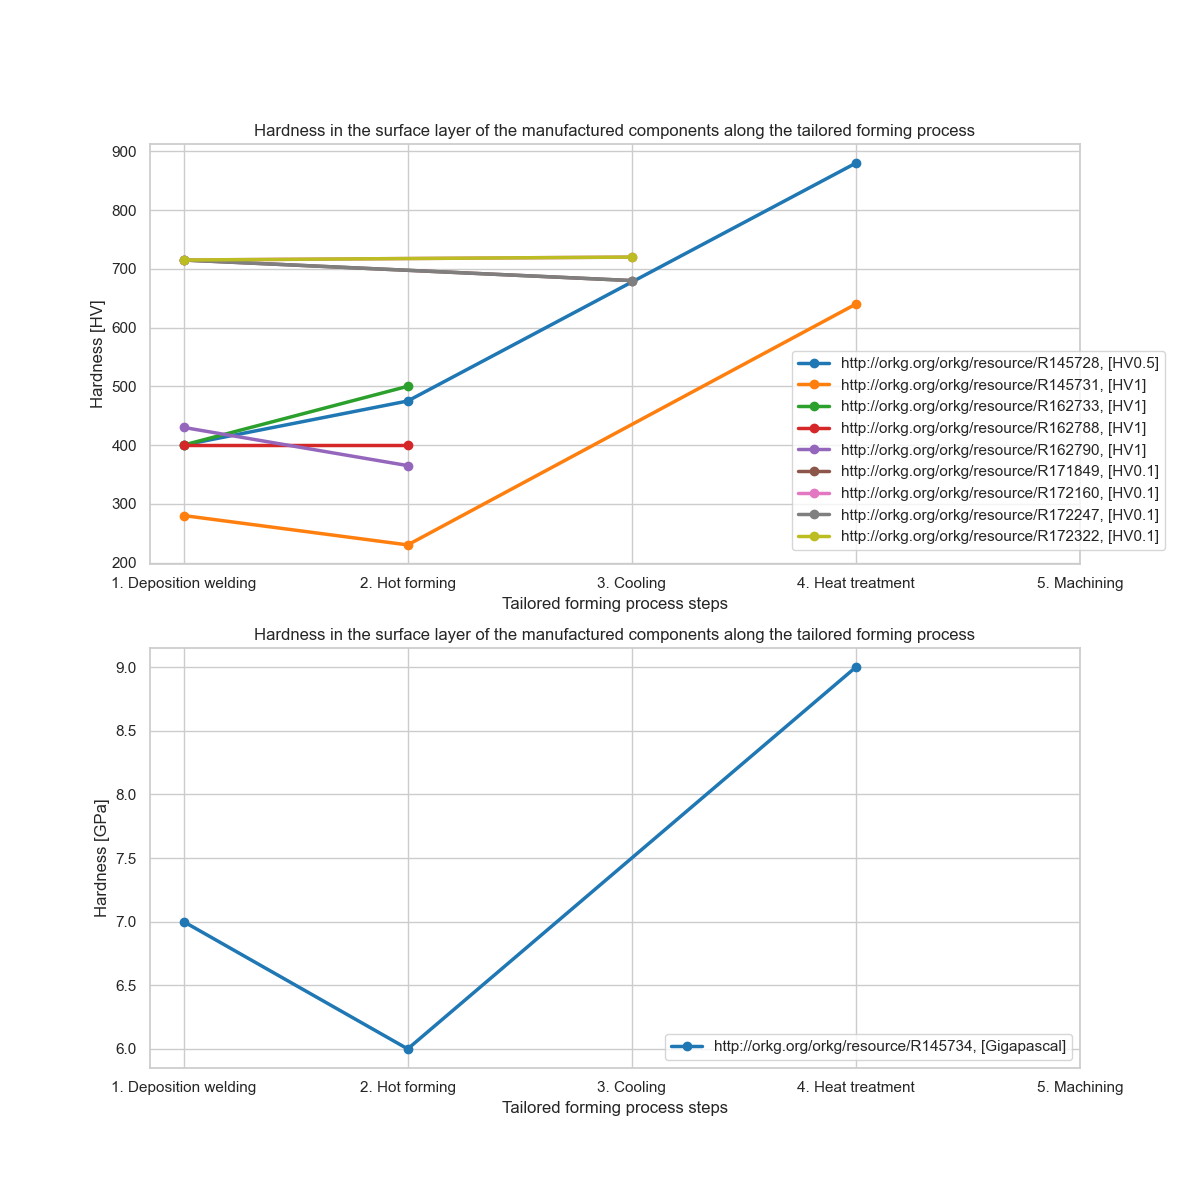

In [65]:
tf_data['calc_value'] = tf_data['num_value'].fillna(tf_data['avg_range'])
hardness_data = tf_data.query('quality == "Hardness" and layer == "Cladding layer"')[['contrib_url','step_number', 'step_name', 'calc_value', 'unit']]
grouped_hardness = hardness_data.groupby('contrib_url')

fig, (ax1, ax2) = plt.subplots(2)
fig.set_size_inches(12, 12)

for name, group in grouped_hardness:
    if (group['unit'][:1].item() != 'Gigapascal') :
        ax1.plot(group['step_number'], group['calc_value'], marker='o', linewidth=2.5, label=name+', ['+group['unit'][:1].item()+']')
    else:
        ax2.plot(group['step_number'], group['calc_value'], marker='o', linewidth=2.5, label=name+', ['+group['unit'][:1].item()+']')

ax1.set_title('Hardness in the surface layer of the manufactured components along the tailored forming process')
ax1.set_xticks(steps['step_number'])
ax1.set_xticklabels(steps['step'])
ax1.set_xlabel('Tailored forming process steps')
ax1.set_ylabel('Hardness [HV]')
legend1 = ax1.legend(loc='center right', bbox_to_anchor=(1.1, 0.27))

ax2.set_title('Hardness in the surface layer of the manufactured components along the tailored forming process')
ax2.set_xticks(steps['step_number'])
ax2.set_xticklabels(steps['step'])
ax2.set_xlabel('Tailored forming process steps')
ax2.set_ylabel('Hardness [GPa]')
legend2 = ax2.legend(loc='lower right')

plt.ion()
plt.show()

## 4. Question: For which material combinations can defects occur in the manufactured components in which tailored forming process steps?

In [66]:
defects_data = tf_data[((tf_data.quality == 'Pores') | (tf_data.quality == 'Mannesmann effect') | (tf_data.quality == 'Cracks')) & (tf_data.textual_value == 'true')][['contrib_url', 'component', 'layer', 'material', 'quality', 'step_name', 'step_number']]
defects_data_complete = defects_data.merge(tf_data, on=['contrib_url', 'step_name'], how='left')[['contrib_url', 'component_x', 'layer_x', 'material_x', 'layer_y', 'material_y', 'quality_x', 'step_name', 'step_number_x']].drop_duplicates()

to_delete = defects_data_complete[defects_data_complete.layer_x == defects_data_complete.layer_y]
final_defect_df = defects_data_complete.drop(to_delete.index, inplace=False)
final_defect_df.rename(columns= {'component_x':'component','layer_x':'layer_with_defect','material_x':'material_with_defect', 'layer_y':'other_layer', 'material_y':'other_material', 'quality_x':'defect', 'step_number_x':'step_number'})

,contrib_url,component,layer_with_defect,material_with_defect,other_layer,other_material,defect,step_name,step_number
0,http://orkg.org/orkg/resource/R145728,Bearing washer,Cladding layer,100Cr6,Base material,C22.8,Pores,Machining,5
9,http://orkg.org/orkg/resource/R145731,Bearing washer,Cladding layer,41Cr4,Base material,C22.8,Pores,Deposition welding,1
15,http://orkg.org/orkg/resource/R145731,Bearing washer,Cladding layer,41Cr4,Base material,C22.8,Pores,Hot forming,2
24,http://orkg.org/orkg/resource/R171849,Shaft with bearing seat,Base material,20MnCr5,Cladding layer,X45CrSi9-3,Mannesmann effect,Cooling,3
30,http://orkg.org/orkg/resource/R172160,Shaft with bearing seat,Base material,20MnCr5,Cladding layer,X45CrSi9-3,Mannesmann effect,Cooling,3
36,http://orkg.org/orkg/resource/R172247,Shaft with bearing seat,Base material,20MnCr5,Cladding layer,X45CrSi9-3,Mannesmann effect,Cooling,3
42,http://orkg.org/orkg/resource/R172322,Shaft with bearing seat,Base material,20MnCr5,Cladding layer,X45CrSi9-3,Mannesmann effect,Cooling,3


## 5. Question: What lifetimes can be achieved for manufactured components depending on the material combination?

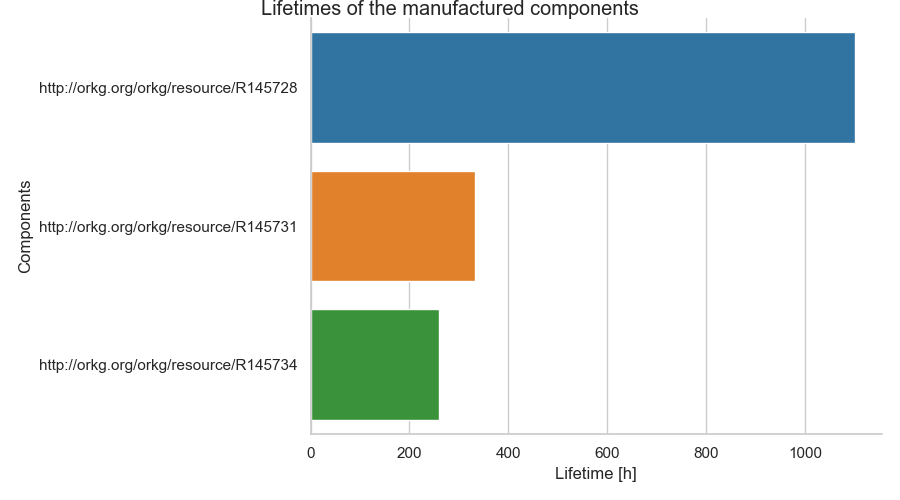

In [67]:
fatigue_data = tf_data[(tf_data.quality == 'Fatigue') & (tf_data.step_number == 5)][['contrib_url', 'component', 'calc_value', 'unit']]

g = sns.catplot(x='calc_value', y='contrib_url', data=fatigue_data, kind='bar', height=5, aspect=1.8, facet_kws={'legend_out': True})
g.fig.suptitle('Lifetimes of the manufactured components', y=1.0)
g.set(xlabel='Lifetime [h]', ylabel='Components')
plt.show()

## 6. Question: What manufacturing methods have been used in the individual steps of the tailored forming processes described to build which component?

In [74]:
method_data = tf_data.loc[:,['contrib_url','component', 'step_number', 'step_name', 'manufacture_method']].drop_duplicates().sort_values('step_number')
method_data.pivot(index=['contrib_url', 'component'], columns=['step_number', 'step_name'], values='manufacture_method').fillna('--', inplace=False)

,step_number,1,2,3,4,5
,step_name,Deposition welding,Hot forming,Cooling,Heat treatment,Machining
contrib_url,component,,,,,
http://orkg.org/orkg/resource/R145728,Bearing washer,Plasma-transferred arc welding,Upsetting,--,Hardening,Grinding
http://orkg.org/orkg/resource/R145731,Bearing washer,Plasma-transferred arc welding,Die forging,--,Hardening,Turning
http://orkg.org/orkg/resource/R145734,Bearing washer,Laser hot-wire cladding,Die forging,--,Hardening,Turning
http://orkg.org/orkg/resource/R162733,Shaft with bearing seat,Plasma-transferred arc welding,Cross-wedge-rolling,--,--,--
http://orkg.org/orkg/resource/R162788,Shaft with bearing seat,Plasma-transferred arc welding,Cross-wedge-rolling,--,--,--
http://orkg.org/orkg/resource/R162790,Shaft with bearing seat,Plasma-transferred arc welding,Cross-wedge-rolling,--,--,--
http://orkg.org/orkg/resource/R171849,Shaft with bearing seat,Laser hot-wire cladding,Cross-wedge-rolling,Air flow,--,--
http://orkg.org/orkg/resource/R172160,Shaft with bearing seat,Laser hot-wire cladding,Cross-wedge-rolling,Water bath,--,--


## 7. Question: How often are which manufacturing methods used in total in all described processes?

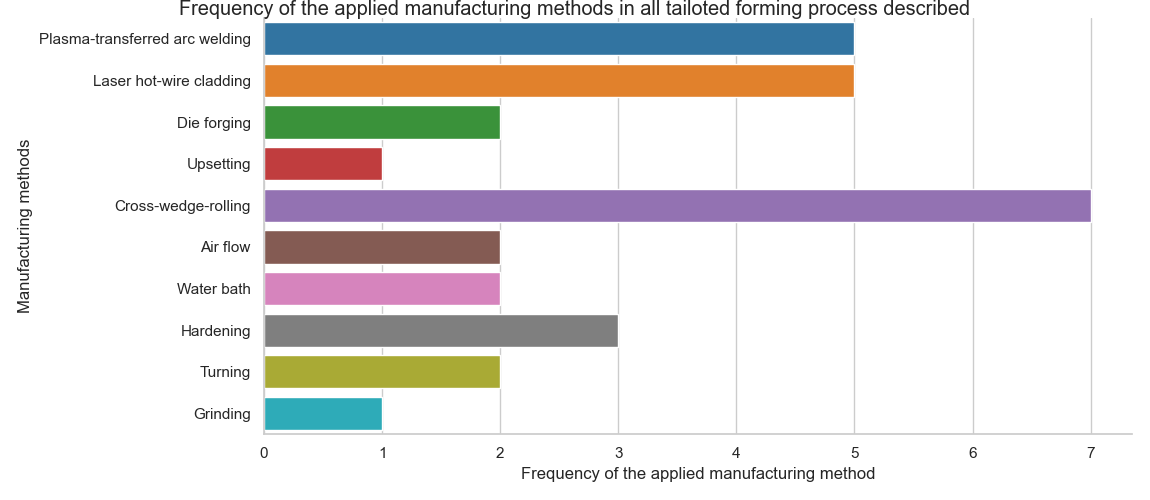

In [78]:
g = sns.catplot(y='manufacture_method', data=method_data, kind='count', height=5, aspect=2.3, facet_kws={'legend_out': True})
g.fig.suptitle('Frequency of the applied manufacturing methods in all tailoted forming process described', y=1.0)
g.set(xlabel='Frequency of the applied manufacturing method', ylabel='Manufacturing methods')
plt.show()